In [1]:
%pylab inline
matplotlib.style.use("ggplot")
%cd ~/LabWorkbookForTrello/
import workbook
import pandas as pd
import collections
reload(workbook)
wb = workbook.ExperimentRepository()

Populating the interactive namespace from numpy and matplotlib
/Users/michael/LabWorkbookForTrello


#(BROKEN) Trying to reproduce the paper

- Batch size: 128
- Layer depth: 20 layers.
- Architecture: No ReLU at the end. Batch norm before adding.

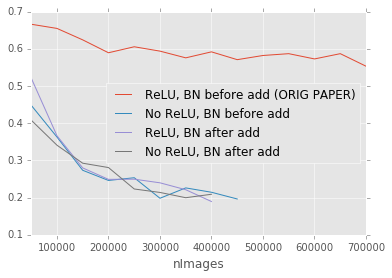

In [49]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "ReLU, BN before add (ORIG PAPER)",
    "201601102044-01lkOBJQu5": "No ReLU, BN before add",
    "201601102047-YybNsWu8zs": "ReLU, BN after add",
    "201601102047-jBrez4iUNB": "No ReLU, BN after add",
}, "Testing Error.csv","error")
df.drop(np.nan, 0).plot()

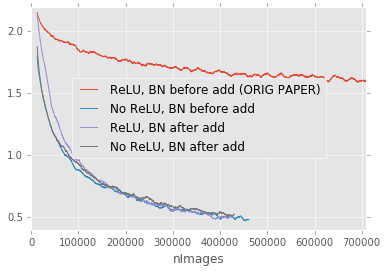

In [50]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "ReLU, BN before add (ORIG PAPER)",
    "201601102044-01lkOBJQu5": "No ReLU, BN before add",
    "201601102047-YybNsWu8zs": "ReLU, BN after add",
    "201601102047-jBrez4iUNB": "No ReLU, BN after add",
}, "Training loss.csv","loss")
pd.rolling_mean(df, 100).plot()


Oops! I should not have a ReLU just before the softmax!

201601102127-YCl5TEh7Wm is just like 201601102039-wgq6T6HuK3 but the
ReLU just before the softmax is gone... The difference is extremely
pronounced.

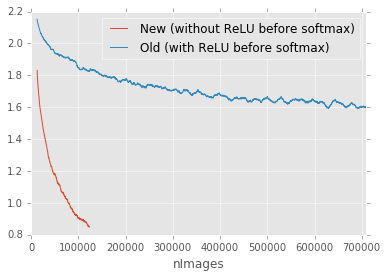

In [51]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "Old (with ReLU before softmax)",
    "201601102127-YCl5TEh7Wm": "New (without ReLU before softmax)",
    #"201601102044-01lkOBJQu5": "Best (No ReLU, BN before add)", # this doesn't have ReLU
}, "Training loss.csv","loss")
#}, "Testing Error.csv","error")
pd.rolling_mean(df, 100).plot()

# (SUCCESS) Reproduce the paper. Architecture considerations.

- Batch size: 128
- Layer depth: 20 layers.

Within each block, the paper uses a batch norm before the addition and
a ReLU just after the addition.


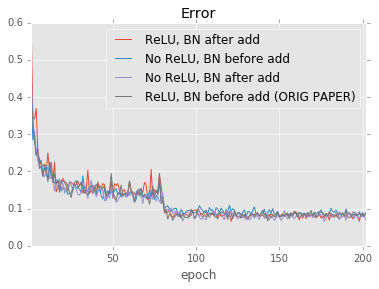

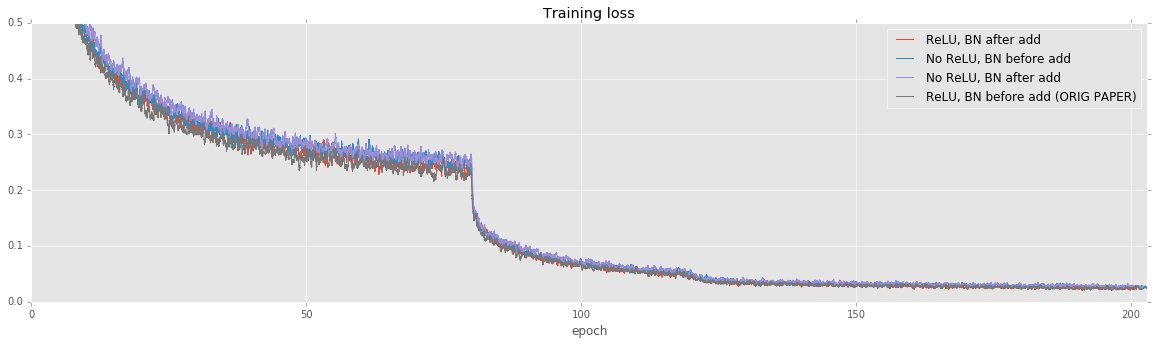

In [21]:
experiments = {
"201601102147-dmFfZATnYp": "ReLU, BN before add (ORIG PAPER)",
"201601102148-JGFRVum2Px": "No ReLU, BN before add",
"201601102148-PWCzZEoKlq": "ReLU, BN after add",
"201601102149-BxAtaPsjip": "No ReLU, BN after add",
}
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
pd.rolling_mean(df_loss, 100).plot(title="Training loss", figsize=(20,5), ylim=(0, 0.5))
df_err = wb.meld_csv(experiments, "Testing Error.csv","error")
df_err.index /= 50000.0; df_err.index.name = "epoch"
df_err.drop(np.nan, 0).plot(title="Error")

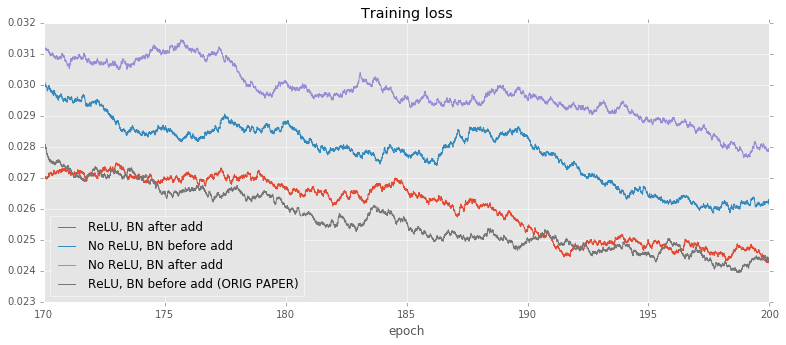

In [22]:
# Take a look at the last few iterations
df = pd.ewma(df_loss, 1000).loc[170:200].plot(title="Training loss",figsize=(13,5))

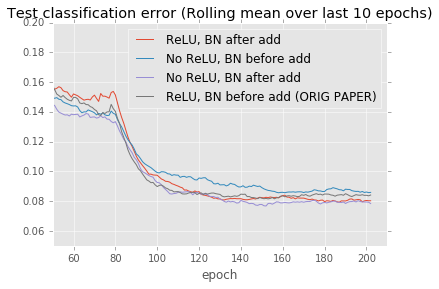

In [24]:
pd.ewma(df_err, 10).plot(xlim=(50,210), ylim=(0.05,0.2), title="Test classification error (Rolling mean over last 10 epochs)")

In [25]:
df_err.loc[200]
# But there is HUGE variance in the last few ones...
# Actual paper's score was 8.75.


ReLU, BN after add                  0.083496
No ReLU, BN before add              0.089355
No ReLU, BN after add               0.079102
ReLU, BN before add (ORIG PAPER)    0.084473
Name: 200.0, dtype: float64

# (SUCCESS) Impact of network size

In [0]:
import bokeh.plotting as bp
import bokeh.charts as bc
bp.output_notebook()
bc.Line(df_loss.iloc[:,0]).show()

In [2]:
experiments = collections.OrderedDict([
("201601102147-dmFfZATnYp", "Nsize=3 (ORIG PAPER), 20 layers"),
("201601111527-cVRVX20oIx", "Nsize=5, 32 layers"),
("201601111527-OlgppHl97y", "Nsize=7, 44 layers"),
("201601111527-iNT9lvorNt", "Nsize=9, 56 layers"),
("201601111958-eYtj2JhWTU", "Nsize=18, 110 layers, fancy policy"),
])
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
df_err = wb.meld_csv(experiments, "Testing Error.csv","error")
df_err = df_err.sort_index(na_position='first')
df_err.index /= 50000.0; df_err.index.name = "epoch"

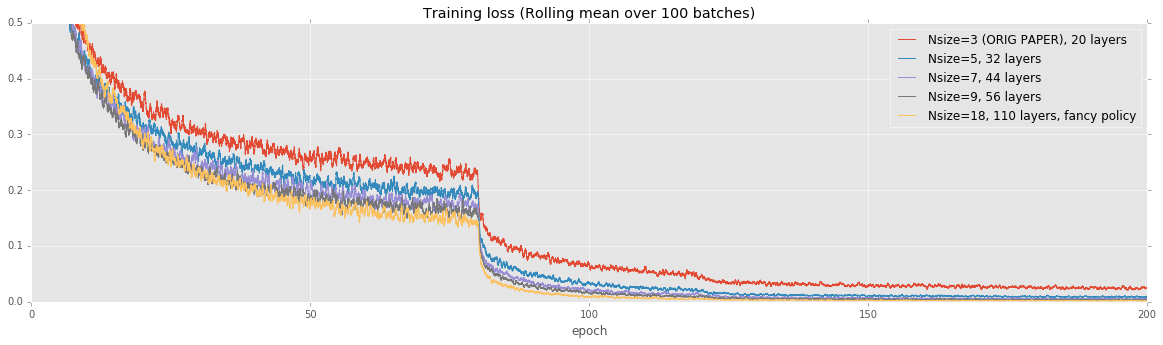

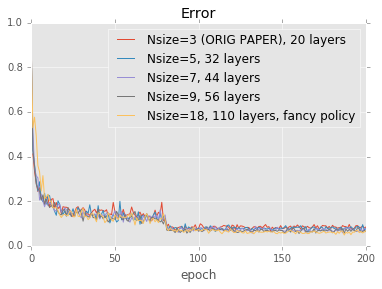

In [62]:
pd.rolling_mean(df_loss, 100).plot(title="Training loss (Rolling mean over 100 batches)", figsize=(20,5),
                                   xlim=(0,200), ylim=(0, 0.5))
df_err.plot(title="Error", xlim=(0, 200))

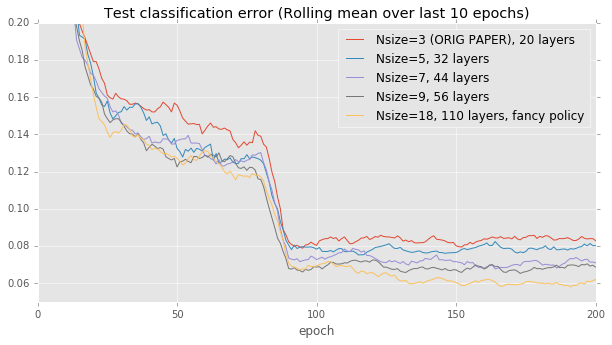

In [5]:
pd.rolling_mean(df_err, 10).plot(xlim=(0,200), ylim=(0.05,0.2), figsize=(10,5), title="Test classification error (Rolling mean over last 10 epochs)")

In [13]:
df_err.iloc[196:201].std()

Nsize=3 (ORIG PAPER), 20 layers       0.004573
Nsize=5, 32 layers                    0.011451
Nsize=7, 44 layers                    0.006902
Nsize=9, 56 layers                    0.008192
Nsize=18, 110 layers, fancy policy    0.004645
dtype: float64

# More Pandas shaping things

In [75]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                   'C' : np.random.randn(8),
                   'D' : np.random.randn(8)})


In [83]:
df[df.A=="foo"].sum()

A      foofoofoofoofoo
B    onetwotwoonethree
C             -4.91672
D              1.98365
dtype: object

In [79]:
df.groupby('A').sum()

            C         D
A                      
bar  0.108936 -1.507688
foo -4.916723  1.983646